In [1]:
import numpy as np
import pandas as pd
from spec_id import Median_w_Error, Median_w_Error_cont,Gen_spec
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from vtl.Readfile import Readfile
from glob import glob
from astropy.io import fits, ascii
from astropy.table import Table
from scipy.interpolate import interp1d
import seaborn as sea
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})
colmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)

In [2]:
galDB = pd.read_pickle('../data/upd_galDB.pkl')
lzDB = galDB.query('z_grism < 1.16')
mzDB = galDB.query('1.16 < z_grism < 1.3')
hzDB = galDB.query('1.3 < z_grism < 1.45')
uhzDB = galDB.query('1.45 < z_grism')
metal=np.round(np.arange(0.002,0.031,0.001),3)
age=np.round(np.arange(.5,6.1,.1),1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

In [8]:
lzDB

,gids,z_grism,z_grism_+,z_grism_-,Z,Z_l,Z_h,Zx,Zx_l,Zx_h,...,d_l,d_h,dx,dx_l,dx_h,l_mass,SNR,rf_lmass,UV,VJ
0,n16758,1.015,0.002405,0.002405,0.023,0.006,0.005,0.022986,0.006004,0.004882,...,0.070,0.100,0.096192,0.066132,0.104208,10.83,10.148602,10.85,2.020510,1.424767
4,n23435,1.139,0.004810,0.007214,0.014,0.008,0.011,0.014008,0.008192,0.010661,...,0.218,0.253,0.382766,0.200401,0.270541,10.27,4.401724,10.31,1.806509,1.149128
6,n32566,1.148,0.004810,0.002405,0.021,0.010,0.006,0.020517,0.009483,0.006733,...,0.238,0.201,0.350701,0.188377,0.250501,10.61,6.591287,10.61,1.788819,1.164701
7,n34694,1.145,0.002405,0.002405,0.021,0.009,0.006,0.020293,0.008305,0.006453,...,0.182,0.121,0.254509,0.136273,0.166333,10.94,9.889953,10.96,1.703197,1.195862
9,n37955,1.027,0.004810,0.002405,0.021,0.012,0.006,0.020124,0.011615,0.007238,...,0.277,0.222,0.569138,0.246493,0.252505,10.85,7.301576,10.84,1.988622,1.294053
13,s39170,1.023,0.002405,0.002405,0.023,0.006,0.005,0.022986,0.006172,0.004994,...,0.074,0.078,0.086172,0.060120,0.092184,11.09,20.847010,11.09,2.065809,1.138585
14,s39241,1.017,0.002405,0.002405,0.024,0.006,0.004,0.023884,0.005555,0.004265,...,0.200,0.049,0.210421,0.110220,0.138277,10.87,12.383246,10.87,1.955526,1.163373
15,s39631,1.057,0.002405,0.009619,0.015,0.007,0.009,0.014569,0.006677,0.009539,...,0.200,0.079,0.226453,0.126253,0.152305,10.69,9.169197,10.68,1.944206,1.106997
24,s42221,1.018,0.004810,0.004810,0.022,0.010,0.006,0.021864,0.009932,0.005723,...,0.216,0.115,0.220441,0.136273,0.194389,10.51,7.666466,10.51,1.781392,1.055335
25,s43615,1.020,0.002405,0.004810,0.022,0.008,0.005,0.021078,0.007463,0.006060,...,0.175,0.209,0.498998,0.174349,0.210421,10.69,6.920919,10.69,2.026586,1.396011


In [6]:
# galDB['Z'] = np.zeros(len(galDB.index))
# galDB['Z_l'] = np.zeros(len(galDB.index))
# galDB['Z_h'] = np.zeros(len(galDB.index))
# galDB['Zx'] = np.zeros(len(galDB.index))
# galDB['Zx_l'] = np.zeros(len(galDB.index))
# galDB['Zx_h'] = np.zeros(len(galDB.index))

# galDB['t'] = np.zeros(len(galDB.index))
# galDB['t_l'] = np.zeros(len(galDB.index))
# galDB['t_h'] = np.zeros(len(galDB.index))
# galDB['tx'] = np.zeros(len(galDB.index))
# galDB['tx_l'] = np.zeros(len(galDB.index))
# galDB['tx_h'] = np.zeros(len(galDB.index))

# galDB['tau'] = np.zeros(len(galDB.index))
# galDB['tau_l'] = np.zeros(len(galDB.index))
# galDB['tau_h'] = np.zeros(len(galDB.index))
# galDB['taux'] = np.zeros(len(galDB.index))
# galDB['taux_l'] = np.zeros(len(galDB.index))
# galDB['taux_h'] = np.zeros(len(galDB.index))

# galDB['d'] = np.zeros(len(galDB.index))
# galDB['d_l'] = np.zeros(len(galDB.index))
# galDB['d_h'] = np.zeros(len(galDB.index))
# galDB['dx'] = np.zeros(len(galDB.index))
# galDB['dx_l'] = np.zeros(len(galDB.index))
# galDB['dx_h'] = np.zeros(len(galDB.index))

In [4]:
galDB.to_pickle('../data/upd_galDB.pkl')

In [28]:
d,prd = np.load('../data/dust_prior.npy')

np.trapz(prd,d)

1.0

In [3]:
gs = GridSpec(2,5)
for i in galDB.index:
    Z,PZ = np.load('../chidat/{0}_full_fit_Z_pos.npy'.format(galDB.gids[i]))
    t,Pt = np.load('../chidat/{0}_full_fit_t_pos.npy'.format(galDB.gids[i]))
    ult,Ptau = np.load('../chidat/{0}_full_fit_tau_pos.npy'.format(galDB.gids[i]))
    z,Pz = np.load('../chidat/{0}_full_fit_rs_pos.npy'.format(galDB.gids[i]))
    d,Pd = np.load('../chidat/{0}_full_fit_d_pos.npy'.format(galDB.gids[i]))
    
    medZ,mler,mher = Median_w_Error_cont(PZ,Z)
    galDB['Zx'][i] = medZ
    galDB['Zx_l'][i] = mler
    galDB['Zx_h'][i] = mher
    
    medZ,mler,mher = Median_w_Error(PZ,Z)
    galDB['Z'][i] = medZ
    galDB['Z_l'][i] = mler
    galDB['Z_h'][i] = mher
    
    medt,mler,mher = Median_w_Error_cont(Pt,t)
    galDB['tx'][i] = medt
    galDB['tx_l'][i] = mler
    galDB['tx_h'][i] = mher
    
    medt,mler,mher = Median_w_Error(Pt,t)
    galDB['t'][i] = medt
    galDB['t_l'][i] = mler
    galDB['t_h'][i] = mher
    
    medtau,mler,mher = Median_w_Error_cont(Ptau,ult)
    galDB['taux'][i] = medtau
    galDB['taux_l'][i] = mler
    galDB['taux_h'][i] = mher
    
    medtau,mler,mher = Median_w_Error(Ptau,ult)
    galDB['tau'][i] = medtau
    galDB['tau_l'][i] = mler
    galDB['tau_h'][i] = mher
    
    medd,mler,mher = Median_w_Error_cont(Pd,d)
    galDB['dx'][i] = medd
    galDB['dx_l'][i] = mler
    galDB['dx_h'][i] = mher
    
    medd,mler,mher = Median_w_Error(Pd,d)
    galDB['d'][i] = medd
    galDB['d_l'][i] = mler
    galDB['d_h'][i] = mher
    
    galDB['z_grism'][i] = z[Pz == max(Pz)][0]
    
#     sp = Gen_spec(galDB.gids[i],z[Pz == max(Pz)][0],minwv=8000,maxwv=11100)
#     sp.Fit_lwa(galDB.Z[i],galDB.t[i],galDB.z_grism[i],galDB.d[i],metal,age,tau)

   
#     plt.figure(figsize=[8,8])
#     plt.subplot(gs[0,:])
#     plt.errorbar(sp.gal_wv_rf,sp.gal_fl, sp.gal_er,linestyle='None', marker='o', markersize=3, color='r')
#     plt.plot(sp.gal_wv_rf,sp.fl,'k')
#     plt.title(galDB.gids[i])
    
#     plt.subplot(gs[1,0])
#     plt.plot(Z,PZ)
#     plt.axvline(galDB.Zx[i])
#     plt.axvline(medZ,color='r')
    
#     plt.subplot(gs[1,1])
#     plt.plot(t,Pt)
#     plt.axvline(galDB.tx[i])
#     plt.axvline(medt,color='r')

#     plt.subplot(gs[1,2])
#     plt.plot(ult,Ptau)
#     plt.axvline(galDB.taux[i])
#     plt.axvline(medtau,color='r')

#     plt.subplot(gs[1,3])
#     plt.plot(z,Pz)
#     plt.axvline(galDB.z_grism[i])
    
#     plt.subplot(gs[1,4])
#     plt.plot(d,Pd)
#     plt.axvline(galDB.dx[i])
#     plt.axvline(medd,color='r')


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

In [9]:
galDB

,bfZ,bfd,bft,bftau,bfz,gids
0,0.025,0.6,4.5,8.90,1.221,s40597
1,0.009,1.0,1.1,0.00,1.209,s40476
2,0.019,0.2,1.9,0.00,1.175,s38785
3,0.021,1.0,1.4,0.00,1.328,s40862
4,0.025,1.0,5.3,9.04,1.595,s40223
5,0.030,0.0,1.3,0.00,1.242,s39805
6,0.030,0.8,0.8,8.00,1.334,s44620
7,0.008,0.2,6.0,0.00,1.057,s39631
8,0.030,0.9,1.9,8.30,1.605,s41520
9,0.019,0.8,2.4,8.48,1.248,n21156


In [13]:
fast_s=Table.read('/Users/vestrada/Desktop/catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/Fast/goodss_3dhst.v4.1.fout',format='ascii').to_pandas()
fast_n=Table.read('/Users/vestrada/Desktop/catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/Fast/goodsn_3dhst.v4.1.fout',format='ascii').to_pandas()


In [14]:
galDB['l_mass'] = np.zeros(len(galDB.index))


In [20]:
for i in galDB.index:
    if galDB.gids[i][0]== 's':
        galDB['l_mass'][i] = fast_s['lmass'][int(galDB.gids[i][1:]) - 1]
        
    if galDB.gids[i][0]== 'n':
        galDB['l_mass'][i] = fast_n['lmass'][int(galDB.gids[i][1:]) - 1]

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
galDB

,gids,z_grism,z_grism_+,z_grism_-,Z,Z_l,Z_h,Zx,Zx_l,Zx_h,...,taux,taux_l,taux_h,d,d_l,d_h,dx,dx_l,dx_h,l_mass
0,n16758,1.015,0.003,0.004,0.027,0.004,0.002,0.026465,0.003872,0.002525,...,0.211820,0.145248,0.193664,0.1,0.086,0.020,0.050100,0.036072,0.070140,10.83
1,n17070,1.175,0.008,0.023,0.017,0.007,0.006,0.016533,0.006228,0.006958,...,0.211820,0.145248,0.272340,0.3,0.238,0.125,0.202405,0.140281,0.222445,10.92
2,n21156,1.248,0.003,0.004,0.012,0.006,0.007,0.011539,0.005780,0.007856,...,0.296548,0.181560,0.205768,0.8,0.199,0.118,0.773547,0.172345,0.144289,11.16
3,n21427,1.506,0.081,0.076,0.019,0.009,0.007,0.018665,0.008417,0.007631,...,0.223924,0.151300,0.211820,0.5,0.328,0.324,0.494990,0.322645,0.328657,10.73
4,n23435,1.139,0.012,0.012,0.013,0.008,0.011,0.012886,0.007407,0.011054,...,0.314704,0.217872,0.326808,0.5,0.334,0.304,0.466934,0.300601,0.336673,10.27
5,n23758,1.161,0.006,0.008,0.007,0.005,0.012,0.006994,0.004601,0.011615,...,0.938061,0.211820,0.187612,1.0,0.136,-0.014,0.947896,0.084168,0.038076,10.97
6,n32566,1.148,0.006,0.006,0.020,0.009,0.007,0.019563,0.008754,0.007238,...,0.459953,0.314704,0.357068,0.6,0.370,0.242,0.549098,0.318637,0.292585,10.61
7,n34694,1.145,0.006,0.007,0.021,0.008,0.005,0.020405,0.007182,0.005667,...,0.163404,0.108936,0.175508,0.7,0.285,0.106,0.601202,0.186373,0.204409,10.94
8,n37686,1.256,0.003,0.003,0.010,0.005,0.007,0.009070,0.003816,0.008136,...,0.229976,0.157352,0.229976,0.9,0.249,0.046,0.823647,0.172345,0.122244,10.89
9,n37955,1.027,0.005,0.008,0.026,0.006,0.003,0.025792,0.006172,0.003142,...,0.720189,0.284444,0.181560,0.8,0.255,0.142,0.793587,0.248497,0.148297,10.85


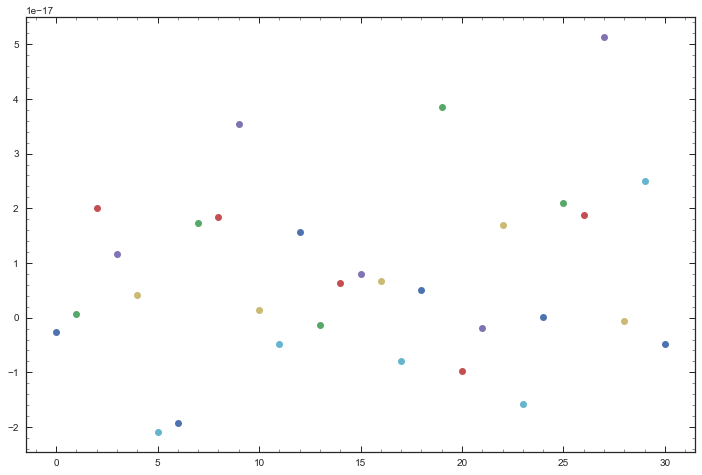

In [9]:
plt.figure(figsize=[12,8])
for i in galDB.index:
    Z,PZ = np.load('../chidat/{0}_full_fit_d_pos.npy'.format(galDB.gids[i]))
    medZ,mler,mher = Median_w_Error_cont(PZ,Z)
    plt.plot(galDB.index[i],medZ - galDB.dx[i],'o')

In [60]:
gs = GridSpec(1,5)

diffZ = []
difft = []
rshift = []
for i in galDB.index:
    if galDB.gids[i] not in ['s39170','n34694','s47677'] and galDB.z_grism[i] < 1.3:
#     if galDB.z_grism[i] < 1.3:
        
        Z,PZ = np.load('../chidat/{0}_full_fit_Z_pos.npy'.format(galDB.gids[i]))
        t,Pt = np.load('../chidat/{0}_full_fit_t_pos.npy'.format(galDB.gids[i]))

        Z,PZ_hm = np.load('../chidat/{0}_full_fit_Z_pos_hb_mask.npy'.format(galDB.gids[i]))
        t,Pt_hm = np.load('../chidat/{0}_full_fit_t_pos_hb_mask.npy'.format(galDB.gids[i]))

        medZ,mler,mher = Median_w_Error(PZ,Z)    
        medt,mler,mher = Median_w_Error(Pt,t)

        medZ_hm,mler,mher = Median_w_Error(PZ_hm,Z)    
        medt_hm,mler,mher = Median_w_Error(Pt_hm,t)

        rshift.append(galDB.z_grism[i])
        
        diffZ.append((medZ-medZ_hm)/medZ)
        difft.append((medt-medt_hm)/medt)





/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


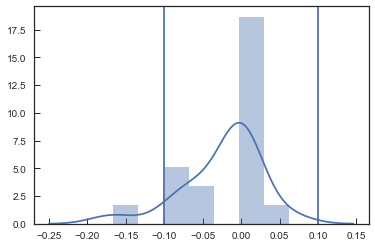

In [61]:
sea.distplot(diffZ)
plt.axvline(0.1)
plt.axvline(-0.1)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


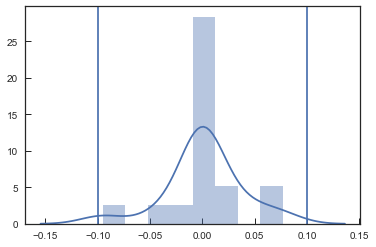

In [62]:
sea.distplot(difft,bins=8)
plt.axvline(0.1)
plt.axvline(-0.1)

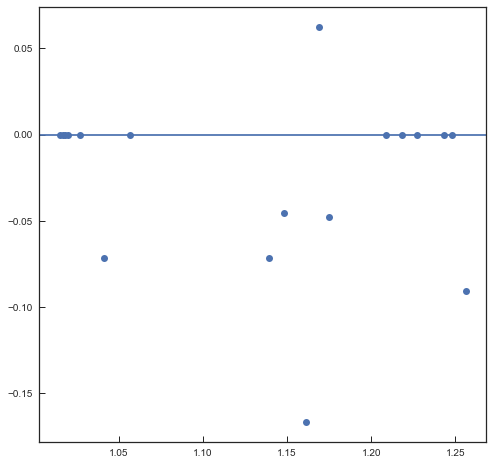

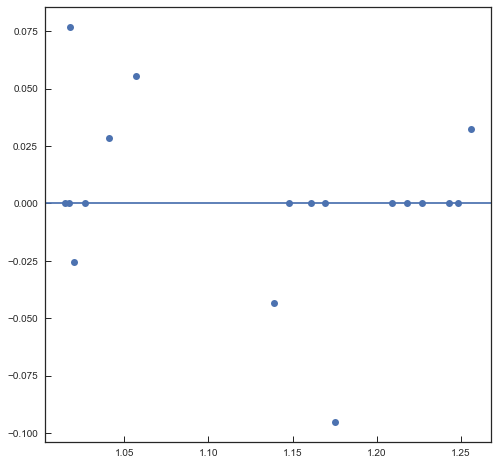

In [63]:
plt.figure(figsize=[8,8])
plt.plot(rshift,diffZ,'o')
plt.axhline(0)
plt.figure(figsize=[8,8])
plt.axhline(0)
plt.plot(rshift,difft,'o')


In [64]:
len(rshift)

18

In [67]:
difft

[0.0,
 -0.09523809523809511,
 0.0,
 -0.04347826086956526,
 0.0,
 0.0,
 0.03225806451612906,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0555555555555556,
 0.0,
 0.0,
 0.0,
 0.07692307692307698,
 -0.025641025641025664,
 0.0285714285714286]